In [150]:
import numpy as np
from numpy import pi, sin, cos, exp
from scipy.optimize import minimize

# Payoff parameters for Prisoner's Dilemma
r = 3.0
p = 1.0
t = 5.0
s = 0.0

# Basis states
C = np.array([1,0], dtype=complex) # |C>
D_ = np.array([0,1], dtype=complex) # |D>
CC = np.kron(C,C)
CD = np.kron(C,D_)
DC = np.kron(D_,C)
DD = np.kron(D_,D_)

# The D operator and J(gamma)
def D_op():
    # D = i sigma_y = [[0,1],[-1,0]]
    return np.array([[0, 1],
                     [-1,0]], dtype=complex)
    
def J(gamma):
    # J = cos(gamma/2)*I - i sin(gamma/2)*D⊗D
    D = D_op()
    DkronD = np.kron(D, D)
    I4 = np.eye(4, dtype=complex)
    return np.cos(gamma/2)*I4 - 1j*np.sin(gamma/2)*DkronD

def Jdagger(gamma):
    return np.conjugate(J(gamma).T)

# Full SU(2) parameterization from Euler angles (psi, theta, phi):
# psi in [0,2pi), theta in [0,pi], phi in [0,2pi)
# def U(psi, theta, phi):
#     # Following standard Euler-angle parameterization of SU(2):
#     return np.array([
#         [cos(theta/2)*exp(1j*(psi+phi)/2), sin(theta/2)*exp(1j*(psi-phi)/2)],
#         [-sin(theta/2)*exp(1j*(-psi - phi)/2), cos(theta/2)*exp(1j*(-psi+phi)/2)]
#     ], dtype=complex)

def U(alpha, beta, phi):
    uni = np.array([[np.exp(-1j * (alpha+beta)/2) * np.cos(phi/2), -1j *np.exp(1j* (alpha-beta)/2)*np.sin(phi/2)],
                    [ -1j*np.exp(-1j* (alpha-beta)/2)*np.sin(phi/2),np.exp(1j * (alpha+beta)/2) * np.cos(phi/2)]])
    return uni

def payoff_A(UA, UB, gamma):
    psi = J(gamma) @ CC
    psi_f = (np.kron(UA, UB) @ psi)
    psi_f = Jdagger(gamma) @ psi_f

    PCC = np.abs(np.dot(CC.conjugate(), psi_f))**2
    PCD = np.abs(np.dot(CD.conjugate(), psi_f))**2
    PDC = np.abs(np.dot(DC.conjugate(), psi_f))**2
    PDD = np.abs(np.dot(DD.conjugate(), psi_f))**2

    return r*PCC + p*PDD + t*PDC + s*PCD

def payoff_B(UA, UB, gamma):
    psi = J(gamma) @ CC
    psi_f = (np.kron(UA, UB) @ psi)
    psi_f = Jdagger(gamma) @ psi_f

    PCC = np.abs(np.dot(CC.conjugate(), psi_f))**2
    PCD = np.abs(np.dot(CD.conjugate(), psi_f))**2
    PDC = np.abs(np.dot(DC.conjugate(), psi_f))**2
    PDD = np.abs(np.dot(DD.conjugate(), psi_f))**2

    return r*PCC + p*PDD + s*PDC + t*PCD

def strategy_from_params(params):
    # Params = [psi, theta, phi]
    # Ensure they are in the correct ranges:
    psi = params[0] % (2*pi)
    theta = params[1] % pi
    phi = params[2] % (2*pi)
    return U(psi, theta, phi), (psi,theta,phi)

def best_response_to_UB(UB_params, gamma, attempts=10):
    # Maximize A's payoff over UA:
    def objA(params):
        UA, _ = strategy_from_params(params)
        UB, _ = strategy_from_params(UB_params)
        return -payoff_A(UA, UB, gamma)
    
    best_val = -np.inf
    best_x = None
    
    for _ in range(attempts):
        x0 = [2*pi*np.random.rand(), pi*np.random.rand(), 2*pi*np.random.rand()]
        res = minimize(objA, x0=x0, method='Nelder-Mead', tol=1e-6, options={'maxiter':500})
        val = -res.fun
        if val > best_val:
            best_val = val
            best_x = res.x

    # Return best response UA found and payoff
    UA, UA_par = strategy_from_params(best_x)
    return UA, UA_par, best_val

def best_response_to_UA(UA_params, gamma, attempts=5):
    # Maximize B's payoff over UB:
    def objB(params):
        UB, _ = strategy_from_params(params)
        UA, _ = strategy_from_params(UA_params)
        return -payoff_B(UA, UB, gamma)

    best_val = -np.inf
    best_x = None

    for _ in range(attempts):
        x0 = [2*pi*np.random.rand(), pi*np.random.rand(), 2*pi*np.random.rand()]
        res = minimize(objB, x0=x0, method='Nelder-Mead', tol=1e-6, options={'maxiter':500})
        val = -res.fun
        if val > best_val:
            best_val = val
            best_x = res.x

    UB, UB_par = strategy_from_params(best_x)
    return UB, UB_par, best_val

def find_approx_equilibrium(gamma, outer_iterations=10, attempts_per_BR=10):
    # We try multiple initial conditions to mitigate local minima:
    best_equilibrium = None
    best_stability = np.inf

    for trial in range(10):  # 5 global attempts
        
        # Random initial strategies:
        UA_params = [2*pi*np.random.rand(), pi*np.random.rand(), 2*pi*np.random.rand()]
        UB_params = [2*pi*np.random.rand(), pi*np.random.rand(), 2*pi*np.random.rand()]

        for _ in range(outer_iterations):
            # Find best response to UB
            UA, UA_par, UA_pay = best_response_to_UB(UB_params, gamma, attempts=attempts_per_BR)
            # Then best response to UA
            UB, UB_par, UB_pay = best_response_to_UA(UA_par, gamma, attempts=attempts_per_BR)

            # Update parameters
            UA_params = UA_par
            UB_params = UB_par

        # Check stability: 
        # Evaluate if small unilateral improvement is possible
        # Compare payoffs at equilibrium vs best responses again:
        UA_final, _ = strategy_from_params(UA_params)
        UB_final, _ = strategy_from_params(UB_params)
        A_curr = payoff_A(UA_final, UB_final, gamma)
        B_curr = payoff_B(UA_final, UB_final, gamma)

        # Best response improvements:
        # Recompute best responses strictly at final point:
        _, _, UA_best_val = best_response_to_UB(UB_params, gamma, attempts=attempts_per_BR)
        _, _, UB_best_val = best_response_to_UA(UA_params, gamma, attempts=attempts_per_BR)

        A_diff = UA_best_val - A_curr
        B_diff = UB_best_val - B_curr
        # Measure stability as sum of positive improvements:
        # If no player can improve > 0.001, considered approx stable
        improvements = 0
        if A_diff > 0.001:
            improvements += A_diff
        if B_diff > 0.001:
            improvements += B_diff

        if improvements < best_stability:
            best_stability = improvements
            best_equilibrium = (UA_params, UB_params, A_curr, B_curr, A_diff, B_diff)
        print(trial,best_equilibrium)
    return best_equilibrium

# Example run for a single gamma value
gamma_test = np.pi/11
equilibrium = find_approx_equilibrium(gamma_test)

if equilibrium is not None:
    UA_par, UB_par, A_pay, B_pay, A_diff, B_diff = equilibrium
    print("Approximate Equilibrium at gamma = ", gamma_test)
    print("UA parameters (psi,theta,phi):", UA_par)
    print("UB parameters (psi,theta,phi):", UB_par)
    print("A payoff:", A_pay, "B payoff:", B_pay)
    print("A unilateral improvement:", A_diff)
    print("B unilateral improvement:", B_diff)
else:
    print("No equilibrium found at gamma =", gamma_test)


0 ((np.float64(3.2108154772350934), np.float64(0.6015829174895897), np.float64(3.1399074305866526)), (np.float64(2.6982905579278778), np.float64(2.1659347270398657), np.float64(3.1428335284887785)), np.float64(1.1587463183866717), np.float64(1.1587494454849978), np.float64(1.7358339685635826e-06), np.float64(0.0))
1 ((np.float64(3.2108154772350934), np.float64(0.6015829174895897), np.float64(3.1399074305866526)), (np.float64(2.6982905579278778), np.float64(2.1659347270398657), np.float64(3.1428335284887785)), np.float64(1.1587463183866717), np.float64(1.1587494454849978), np.float64(1.7358339685635826e-06), np.float64(0.0))
2 ((np.float64(3.2108154772350934), np.float64(0.6015829174895897), np.float64(3.1399074305866526)), (np.float64(2.6982905579278778), np.float64(2.1659347270398657), np.float64(3.1428335284887785)), np.float64(1.1587463183866717), np.float64(1.1587494454849978), np.float64(1.7358339685635826e-06), np.float64(0.0))
3 ((np.float64(3.2108154772350934), np.float64(0.601

In [149]:
# UA_par = (UA_par[0],UA_par[1],np.pi)
# UB_par = (UB_par[0],UB_par[1],np.pi)

# UA_par = (pi,0,pi)
# UB_par = (pi,0,pi)

np.abs(U(*UA_par))

array([[1.11849653e-08, 1.00000000e+00],
       [1.00000000e+00, 1.11849653e-08]])

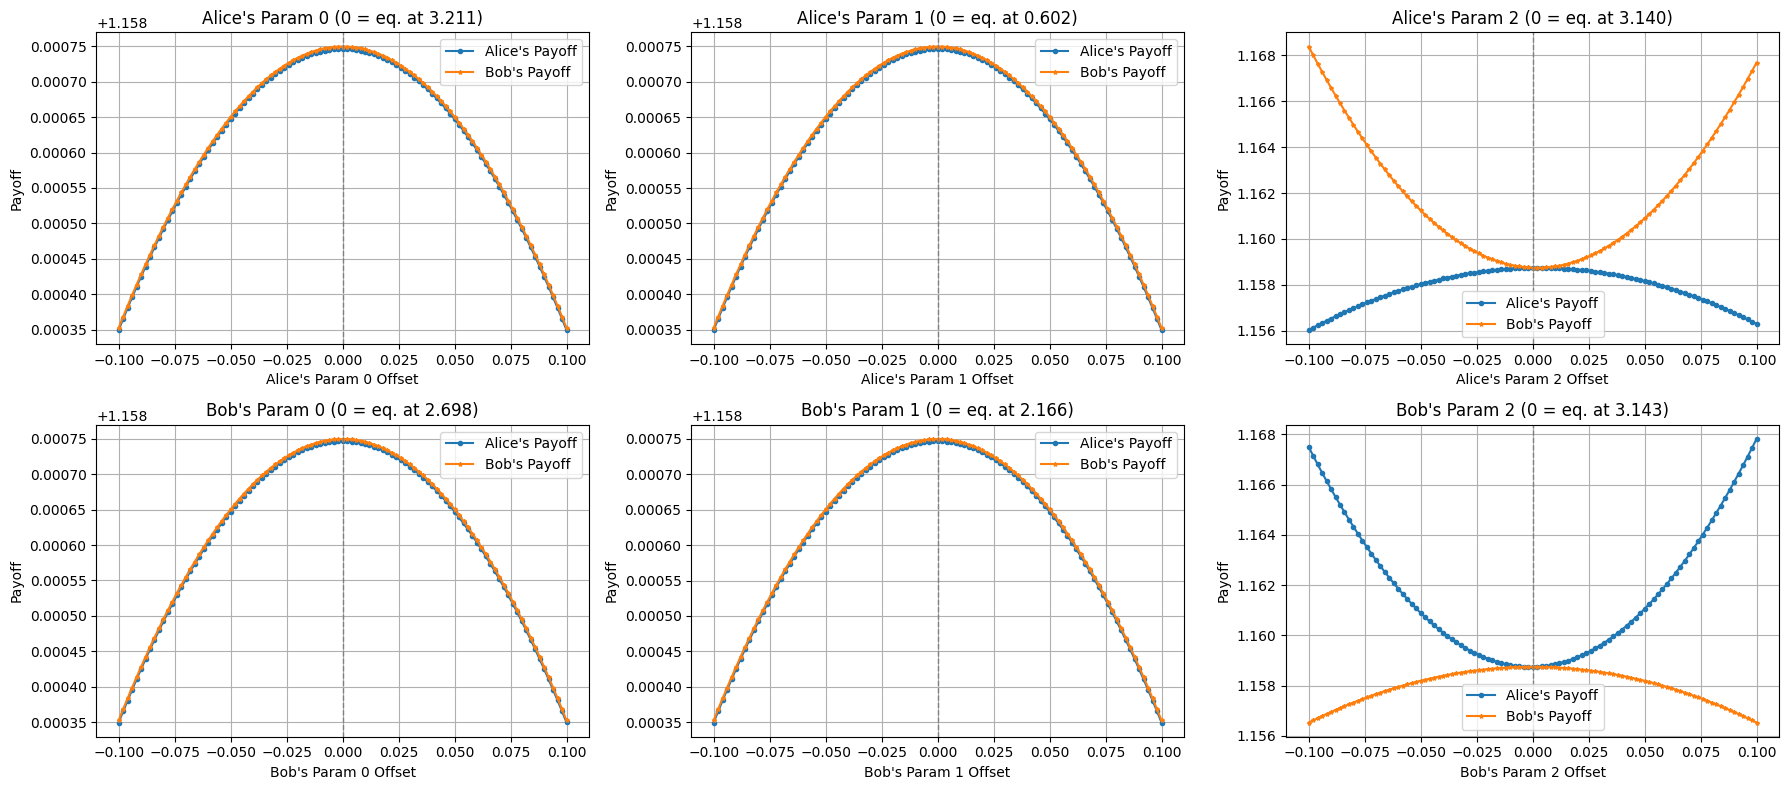

In [151]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming UA_par, UB_par, gaCHANGE THIS SOmma_test, payoff_A, payoff_B, and strategy_from_params 
# are defined from previous calculations

# UA_par = (psi_A, theta_A, phi_A)
# UB_par = (psi_B, theta_B, phi_B)

# We will create a 2x3 grid of subplots:
# Top row: Varying Alice's parameters (0,1,2)
# Bottom row: Varying Bob's parameters (0,1,2)
fig, axes = plt.subplots(2, 3, figsize=(18, 8)) 

variation_range = 0.1
num_points = 101

# (player, param) combinations
players = [("A", 0), ("A", 1), ("A", 2),
           ("B", 0), ("B", 1), ("B", 2)]

for idx, (player_choice, param_index) in enumerate(players):
    row = 0 if player_choice == "A" else 1
    col = param_index
    ax = axes[row, col]
    
    psi_A_eq, theta_A_eq, phi_A_eq = UA_par
    psi_B_eq, theta_B_eq, phi_B_eq = UB_par
    
    if player_choice == 'A':
        base_params = list(UA_par)
        other_params = list(UB_par)
        player_label = "Alice"
    else:
        base_params = list(UB_par)
        other_params = list(UA_par)
        player_label = "Bob"
    
    param_eq = base_params[param_index]
    param_vals = np.linspace(param_eq - variation_range, param_eq + variation_range, num_points)
    offsets = param_vals - param_eq  # Shift so that equilibrium is at 0
    
    payoffsA = np.zeros(num_points)
    payoffsB = np.zeros(num_points)
    
    for i, val in enumerate(param_vals):
        test_params = base_params.copy()
        test_params[param_index] = val
        if player_choice == 'A':
            UA_test, _ = strategy_from_params(test_params)
            UB_test, _ = strategy_from_params(other_params)
        else:
            UB_test, _ = strategy_from_params(test_params)
            UA_test, _ = strategy_from_params(other_params)
        
        A_pay = payoff_A(UA_test, UB_test, gamma_test)
        B_pay = payoff_B(UA_test, UB_test, gamma_test)
        payoffsA[i] = A_pay
        payoffsB[i] = B_pay
    
    # Plot Alice and Bob payoffs against the offset
    ax.plot(offsets, payoffsA, '-o', markersize=3, label="Alice's Payoff")
    ax.plot(offsets, payoffsB, '-*', markersize=3, label="Bob's Payoff")
    
    # Draw a vertical line at offset = 0 (equilibrium point)
    ax.axvline(x=0.0, color='gray', linestyle='--', linewidth=1)
    
    ax.set_xlabel(f"{player_label}'s Param {param_index} Offset")
    ax.set_ylabel("Payoff")
    ax.set_title(f"{player_label}'s Param {param_index} (0 = eq. at {param_eq:.3f})")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()
